In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import calendar


# Optional: set matplotlib inline if using a Jupyter Notebook
%matplotlib inline

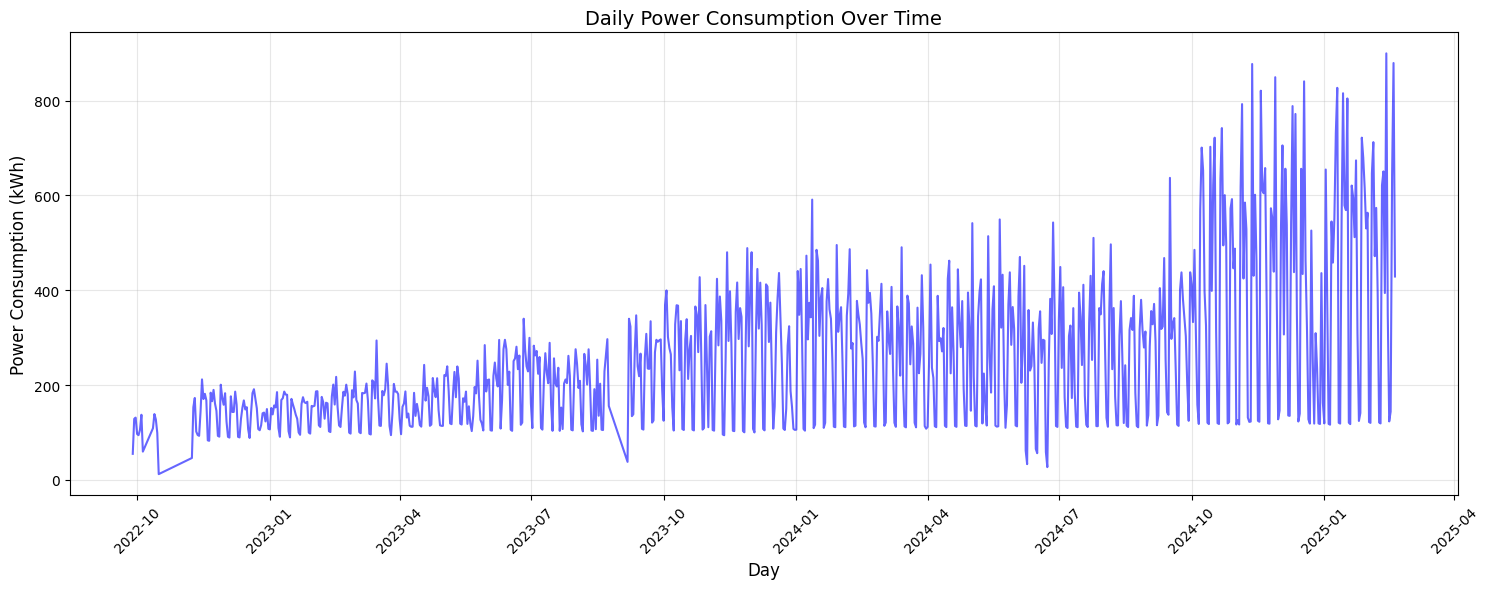

,Chargers,Chargers achteraan,Grid Organi lbc,Solar,Total_consumption,is_festive
Day,,,,,,
2022-09-28,54.7589,0.0000,161.4850,0.0000,54.7589,0
2022-09-29,128.5703,0.0000,396.6727,0.0000,128.5703,0
2022-09-30,131.1694,0.0000,359.5532,0.0000,131.1694,0
2022-10-01,96.6635,0.0000,213.6044,0.0000,96.6635,0
2022-10-02,94.1941,0.0000,205.0945,0.0000,94.1941,0
...,...,...,...,...,...,...
2025-02-15,104.3327,18.8763,352.5995,35.9465,123.2090,0
2025-02-16,119.0974,24.7185,355.8970,56.2186,143.8159,0
2025-02-17,431.0070,211.1560,963.6415,137.7204,642.1630,0


In [2]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('../aggregated_daily_measurements.csv')
df.set_index("Day", inplace=True)
df.index = pd.to_datetime(df.index)

# Combine solar and grid readings, excluding solar before June 2024
df['Total_consumption'] = df['Chargers'] + df['Chargers achteraan'] 

be_holidays = holidays.BE()
df['is_festive'] = df.index.to_series().apply(lambda x: 1 if x in be_holidays else 0)

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df

In [3]:
# Load the data
df = pd.read_csv('../aggregated_daily_measurements.csv')
df.set_index("Day", inplace=True)
df.index = pd.to_datetime(df.index)

# Combine solar and grid readings, excluding solar before June 2024
df['Total_consumption'] = df['Grid Organi lbc'] + df['Solar'].where(df.index >= '2024-06-01', 0) - df['Chargers'] - df['Chargers achteraan'] 

# Drop unwanted columns
df.drop(['Chargers achteraan', 'Solar', 'Chargers', 'Grid Organi lbc'], axis=1, inplace=True)
df.index = df.index.normalize()

# Create a complete date range (including missing dates)
start_date = df.index.min()
end_date = max(df.index.max(), pd.Timestamp('2023-09-06'))  # Extend to Period 2 end
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(full_date_range)  # Add missing dates as NaN

# Add day of the week
df['day_of_week'] = df.index.dayofweek  # 0=Monday, 6=Sunday

# --- Define Periods ---
# Period 1 (to remove)
period1_start = '2022-09-28'
period1_end = '2022-11-08'
df.loc[period1_start:period1_end, 'Total_consumption'] = np.nan  # Mark for removal

df_period1 = df.loc[period1_start:period1_end].copy()
df = df.drop(df_period1.index)

# Period 2 (to interpolate)
period2_start = '2023-08-24'
period2_end = '2023-09-06'
df.loc[period2_start:period2_end, 'Total_consumption'] = np.nan  # Mark for interpolation

# Remove Period 1 and Period 2
df_remaining = df.dropna(subset=['Total_consumption'])

# --- KEY CHANGE: Use ONLY 2023 data (excluding Period 2) to calculate averages ---
df_remaining_2023 = df_remaining[df_remaining.index.year == 2023]  # Filter to 2023
weekly_avg = df_remaining_2023.groupby('day_of_week')['Total_consumption'].mean()

# Fill Period 2 NaN values with 2023 day-of-week averages
for date in pd.date_range(period2_start, period2_end):
    if pd.isna(df.loc[date, 'Total_consumption']):
        day = date.dayofweek
        df.loc[date, 'Total_consumption'] = weekly_avg[day]

# --- Handle Wrong Charger Dates in 2024 by Interpolating Using 2024 Data ---
wrong_chargers_dates = pd.to_datetime([
    '2024-06-08', '2024-06-09', '2024-06-15',
    '2024-06-16', '2024-06-22', '2024-06-23'
])
# Mark these dates as NaN to prepare for interpolation
df.loc[wrong_chargers_dates, 'Total_consumption'] = np.nan

# Compute weekday averages from valid 2024 data (excluding the wrong dates)
df_2024_valid = df[(df.index.year == 2024) & (df['Total_consumption'].notna())]
weekly_avg_2024 = df_2024_valid.groupby('day_of_week')['Total_consumption'].mean()

# Fill in the missing values for the wrong charger dates using the 2024 weekday averages
for date in wrong_chargers_dates:
    day = date.dayofweek
    df.loc[date, 'Total_consumption'] = weekly_avg_2024[day]

# --- Final Cleanup ---
# Drop the 'day_of_week' column (no longer needed)
df = df.drop(columns=['day_of_week'])

# Reset index to make 'Day' a column (not an index)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Day'}, inplace=True)

df = df[df['Day'] >= '2024-07-01']

# Save the final DataFrame (only 'Day' and 'Total_consumption')
df[['Day', 'Total_consumption']].to_csv('../daily_building_consumption_0624.csv', index=False)

# Display the first few rows
print("Final DataFrame:")
print(df.head())

Final DataFrame:
           Day  Total_consumption
600 2024-07-01           300.7035
601 2024-07-02           331.1071
602 2024-07-03           247.1963
603 2024-07-04           318.9897
604 2024-07-05           221.3844


In [6]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('../aggregated_daily_measurements.csv')
df.set_index("Day", inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate Total_consumption as the sum of the two chargers
df['Total_consumption'] = df['Chargers achteraan'] + df['Chargers']

# Drop no-longer needed columns
df.drop(['Chargers achteraan', 'Chargers', 'Solar', 'Grid Organi lbc'], axis=1, inplace=True)
df.index = df.index.normalize()

# Create a complete date range (including missing dates)
start_date = df.index.min()
end_date = max(df.index.max(), pd.Timestamp('2023-09-06'))  # Ensure the end date extends to Period 2
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(full_date_range)

# Add day_of_week column (0=Monday, 6=Sunday) for interpolation purposes
df['day_of_week'] = df.index.dayofweek

# --- Define Periods ---
# Period 1: Data to remove (2022-09-28 to 2022-11-08)
period1_start = '2022-09-28'
period1_end = '2022-11-08'
df.loc[period1_start:period1_end, 'Total_consumption'] = np.nan  # Mark for removal
df_period1 = df.loc[period1_start:period1_end].copy()
df = df.drop(df_period1.index)

# Period 2: Data to interpolate (2023-08-24 to 2023-09-06)
period2_start = '2023-08-24'
period2_end = '2023-09-06'
df.loc[period2_start:period2_end, 'Total_consumption'] = np.nan  # Mark for interpolation

# Remove Period 1 rows (with NaN in Total_consumption)
df_remaining = df.dropna(subset=['Total_consumption'])

# --- Interpolate Period 2 using 2023 weekday averages ---
df_remaining_2023 = df_remaining[df_remaining.index.year == 2023]
weekly_avg = df_remaining_2023.groupby('day_of_week')['Total_consumption'].mean()

for date in pd.date_range(period2_start, period2_end):
    if pd.isna(df.loc[date, 'Total_consumption']):
        day = date.dayofweek
        df.loc[date, 'Total_consumption'] = weekly_avg[day]

# --- Handle Wrong Charger Dates in 2024 by Interpolating Using 2024 Data ---
wrong_chargers_dates = pd.to_datetime([
    '2024-06-08', '2024-06-09', '2024-06-15',
    '2024-06-16', '2024-06-22', '2024-06-23'
])
# Mark these dates as NaN to prepare for interpolation
df.loc[wrong_chargers_dates, 'Total_consumption'] = np.nan

# Compute weekday averages from valid 2024 data (excluding the wrong dates)
df_2024_valid = df[(df.index.year == 2024) & (df['Total_consumption'].notna())]
weekly_avg_2024 = df_2024_valid.groupby('day_of_week')['Total_consumption'].mean()

# Fill in the missing values for the wrong charger dates using the 2024 weekday averages
for date in wrong_chargers_dates:
    day = date.dayofweek
    df.loc[date, 'Total_consumption'] = weekly_avg_2024[day]

# --- Final Cleanup ---
# Remove the 'day_of_week' column as it's no longer needed
df = df.drop(columns=['day_of_week'])

# Reset index so that 'Day' becomes a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'Day'}, inplace=True)

# Save the final DataFrame (only 'Day' and 'Total_consumption')
df[['Day', 'Total_consumption']].to_csv('../daily_cleaned_chargers.csv', index=False)

# Display the first few rows of the final DataFrame
print("Final DataFrame:")
print(df.head())


Final DataFrame:
         Day  Total_consumption
0 2022-11-09           153.2512
1 2022-11-10           172.6536
2 2022-11-11           101.7820
3 2022-11-12            94.4814
4 2022-11-13            92.8091


In [ ]:
df.isna().sum()

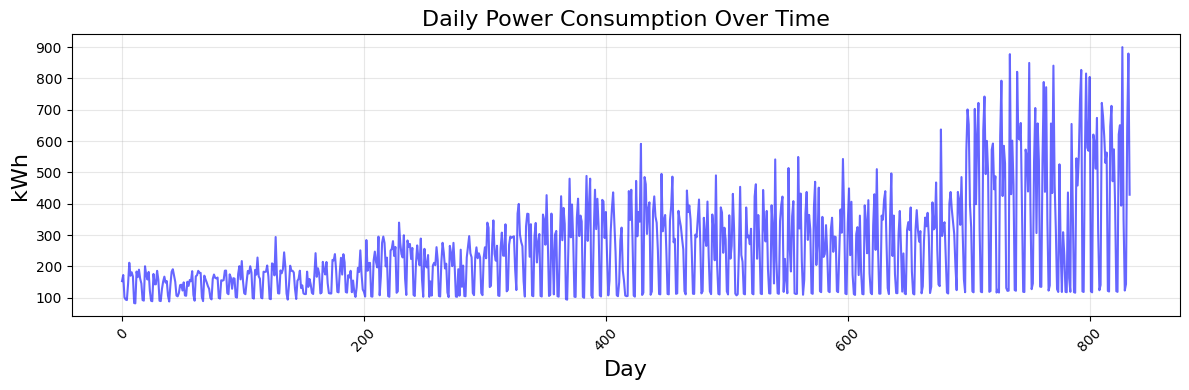

,Day,Total_consumption
0,2022-11-09,153.2512
1,2022-11-10,172.6536
2,2022-11-11,101.7820
3,2022-11-12,94.4814
4,2022-11-13,92.8091
...,...,...
829,2025-02-15,123.2090
830,2025-02-16,143.8159
831,2025-02-17,642.1630
832,2025-02-18,879.3733


In [9]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=16)
plt.xlabel('Day', fontsize=16)
plt.ylabel('kWh', fontsize=16)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df

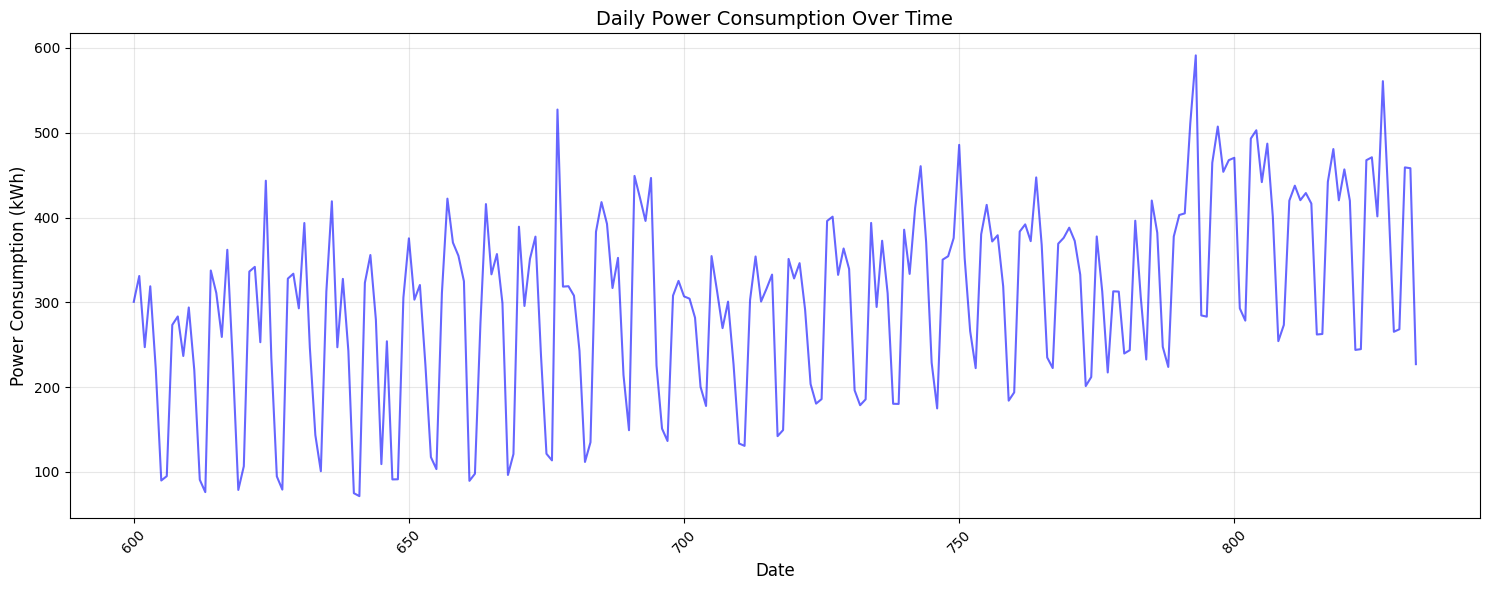

,Day,Total_consumption
600,2024-07-01,300.7035
601,2024-07-02,331.1071
602,2024-07-03,247.1963
603,2024-07-04,318.9897
604,2024-07-05,221.3844
...,...,...
829,2025-02-15,265.3370
830,2025-02-16,268.2997
831,2025-02-17,459.1989
832,2025-02-18,458.2189


In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df

In [ ]:
# Ensure the index is a DatetimeIndex first
df.index = pd.to_datetime(df.index)

# Filter the DataFrame by the date range
df_filtered = df_final.loc['2024-05-01 12:00:00':'2024-08-01 12:00:00']

plt.figure(figsize=(15, 6))
plt.plot(df_filtered.index, df_filtered['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()